In [1]:
from typing import Iterable
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from edgedroid.models.timings import *
logger.enable("edgedroid")

import itertools as it
from collections import deque

import multiprocess as mp
import tqdm.notebook as tqdm

def run_model_against_ttfs(rep: int, model: ExecutionTimeModel, ttfs: Iterable[float]) -> pd.DataFrame:
    duration = 0.0
    rows = deque()
    prev_ttf = 0.0
    
    for step, ttf in enumerate(ttfs):
        execution_time = model.get_execution_time()
        # rtt = ttf / 1.5
        
        step_time = execution_time + ttf
        duration += step_time
        rows.append({
            "rep": rep,
            "step": step,
            "prev_ttf": prev_ttf,
            "ttf": ttf,
            # "rtt": rtt,
            "execution_time": execution_time,
            "step_time": step_time,
            "duration": duration
        })
        
        model.advance(ttf)
        prev_ttf = ttf
        
    return pd.DataFrame(rows)

def eval_model(
        rep: int, 
        model_name_const: Tuple[str, Callable[[float], ExecutionTimeModel]],
        neuro: float, 
        ttfs: Iterable[float]
) -> pd.DataFrame:
    model_name, model_constructor = model_name_const
    model = model_constructor(neuro)
    model_result = run_model_against_ttfs(rep, model, ttfs)
    model_result["model"] = model_name
    model_result["neuroticism"] = neuro
    model_result["rep"] = rep
    return model_result


class CubicETM(MultiCurveFittingExecutionTimeModel):
    _fit_functions = (CubeFit, )

reps = 40
num_steps = 100
ttfs = [[t] * 100 for t in (0.0, 1.0, 2.0, 3.0)]
neuroticism = (0.0, 1.0)
models = {
    "multicurve": lambda neuro: MultiCurveFittingExecutionTimeModel(neuroticism=neuro),
    "cubic": lambda neuro: CubicETM(neuroticism=neuro),
    "1st order median": lambda neuro: FirstOrderAggregateETM(aggregate_fn=np.median),
    "1st order emp. dist.": lambda neuro: FirstOrderETM(),
    "legacy": lambda neuro: LegacyModel()
}

with mp.Pool() as pool:
    futures = deque()
    for params in it.product(range(reps), models.items(), neuroticism, ttfs):
        futures.append(pool.apply_async(eval_model, params))
        
    dfs = deque(maxlen=len(futures))
    for fut in tqdm.tqdm(futures):
        dfs.append(fut.get())

results = pd.concat(dfs)
results

2024-02-18 17:37:02.739 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.739 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.742 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.740 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean


  0%|          | 0/1600 [00:00<?, ?it/s]

2024-02-18 17:37:02.742 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.743 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.742 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:02.740 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:37:03.090 | INFO     | edgedroid.models.timings.curve:__init__:147 - Fitting execution time functions to data...
2024-02-18 17:37:03.096 | INFO     | edgedroid.models.timings.curve:__init__:147 - Fitting execution time functions to data...
2024-02-18 17:37:03.093 | INFO     | edgedroid.models.timings.curve:__init__:147 - Fitting execution time functions to data...
2024-02-18 17:37:03.072 | INFO     | ed

rep  step  prev_ttf  ttf  execution_time  step_time    duration  \
0     0     0       0.0  0.0        4.862317   4.862317    4.862317   
1     0     1       0.0  0.0        4.862317   4.862317    9.724635   
2     0     2       0.0  0.0        4.862317   4.862317   14.586952   
3     0     3       0.0  0.0        4.862317   4.862317   19.449270   
4     0     4       0.0  0.0        4.227849   4.227849   23.677118   
..  ...   ...       ...  ...             ...        ...         ...   
95   39    95       3.0  3.0        4.049000   7.049000  677.093000   
96   39    96       3.0  3.0        4.049000   7.049000  684.142000   
97   39    97       3.0  3.0        4.049000   7.049000  691.191000   
98   39    98       3.0  3.0        4.049000   7.049000  698.240000   
99   39    99       3.0  3.0        4.049000   7.049000  705.289000   

         model  neuroticism  
0   multicurve          0.0  
1   multicurve          0.0  
2   multicurve          0.0  
3   multicurve          0.0  
4   multicurve          0.0  
..         ...          ...  
95      legacy          1.0  
96      legacy          1.0  
97      legacy          1.0  
98      legacy          1.0  
99      legacy          1.0  

[160000 rows x 9 columns]

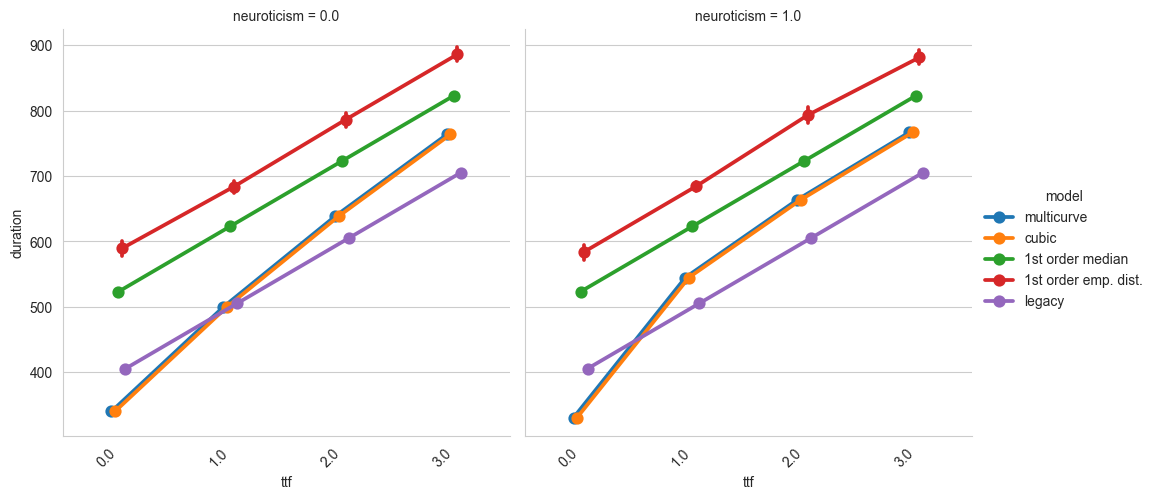

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

fg = sns.catplot(
    kind="point",
    data=results.query("step == 99"),
    x="ttf",
    y="duration",
    hue="model",
    dodge=True,
    col="neuroticism",
)
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()
plt.close()

In [4]:
# autoregressive series of ttfs

def autoreg_ttfs(scale: float, autoreg_coef: float, num_steps: int=100):
    rng = np.random.default_rng()
    ttfs = np.zeros(num_steps, dtype=np.float64)
    ttfs[0] = rng.random() * scale
    
    for i in range(num_steps - 1):
        ttfs[i + 1] = (ttfs[i] * autoreg_coef) + (rng.random() * scale * (1.0 - autoreg_coef))
        
    return ttfs

In [5]:
import multiprocess as mp

autoreg_scales = (1.0, 2.0, 3.0)
autoreg_coefs = (0.25, 0.5, 0.75)

total_evals = len(autoreg_scales) * len(autoreg_coefs) * reps * len(models) * len(neuroticism)

with mp.Pool() as pool, tqdm.tqdm(total=total_evals) as pbar:
    dfs = deque()
    
    for scale, coef in it.product(autoreg_scales, autoreg_coefs):
        futures = deque()
        
        ttfs = autoreg_ttfs(scale, coef)
        for params in it.product(range(reps), models.items(), neuroticism, [ttfs]):
            futures.append(pool.apply_async(eval_model, params))
        
        for fut in futures:
            fut_df = fut.get()
            fut_df["scale"] = scale
            fut_df["coef"] = coef
            dfs.append(fut_df)
            pbar.update(1)
            
results = pd.concat(dfs)
results

  0%|          | 0/3600 [00:00<?, ?it/s]

2024-02-18 17:39:46.501 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.527 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.517 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.499 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.787 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.829 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to_nan_then_mean
2024-02-18 17:39:46.837 | DEBUG    | edgedroid.models.timings.curve:__init__:122 - Curve fitting aggregation function: outliers_to

rep  step  prev_ttf       ttf  execution_time  step_time    duration  \
0     0     0  0.000000  0.132215        4.862317   4.994532    4.994532   
1     0     1  0.132215  0.738227        4.944835   5.683062   10.677595   
2     0     2  0.738227  0.782253        5.195750   5.978003   16.655598   
3     0     3  0.782253  0.285247        5.207039   5.492286   22.147884   
4     0     4  0.285247  0.186594        5.026860   5.213453   27.361337   
..  ...   ...       ...       ...             ...        ...         ...   
95   39    95  1.322174  1.017832        4.049000   5.066832  533.914943   
96   39    96  1.017832  0.945388        4.049000   4.994388  538.909331   
97   39    97  0.945388  1.367215        4.049000   5.416215  544.325547   
98   39    98  1.367215  1.470900        4.049000   5.519900  549.845446   
99   39    99  1.470900  1.616671        4.049000   5.665671  555.511117   

         model  neuroticism  scale  coef  
0   multicurve          0.0    1.0  0.25  
1   multicurve          0.0    1.0  0.25  
2   multicurve          0.0    1.0  0.25  
3   multicurve          0.0    1.0  0.25  
4   multicurve          0.0    1.0  0.25  
..         ...          ...    ...   ...  
95      legacy          1.0    3.0  0.75  
96      legacy          1.0    3.0  0.75  
97      legacy          1.0    3.0  0.75  
98      legacy          1.0    3.0  0.75  
99      legacy          1.0    3.0  0.75  

[360000 rows x 11 columns]

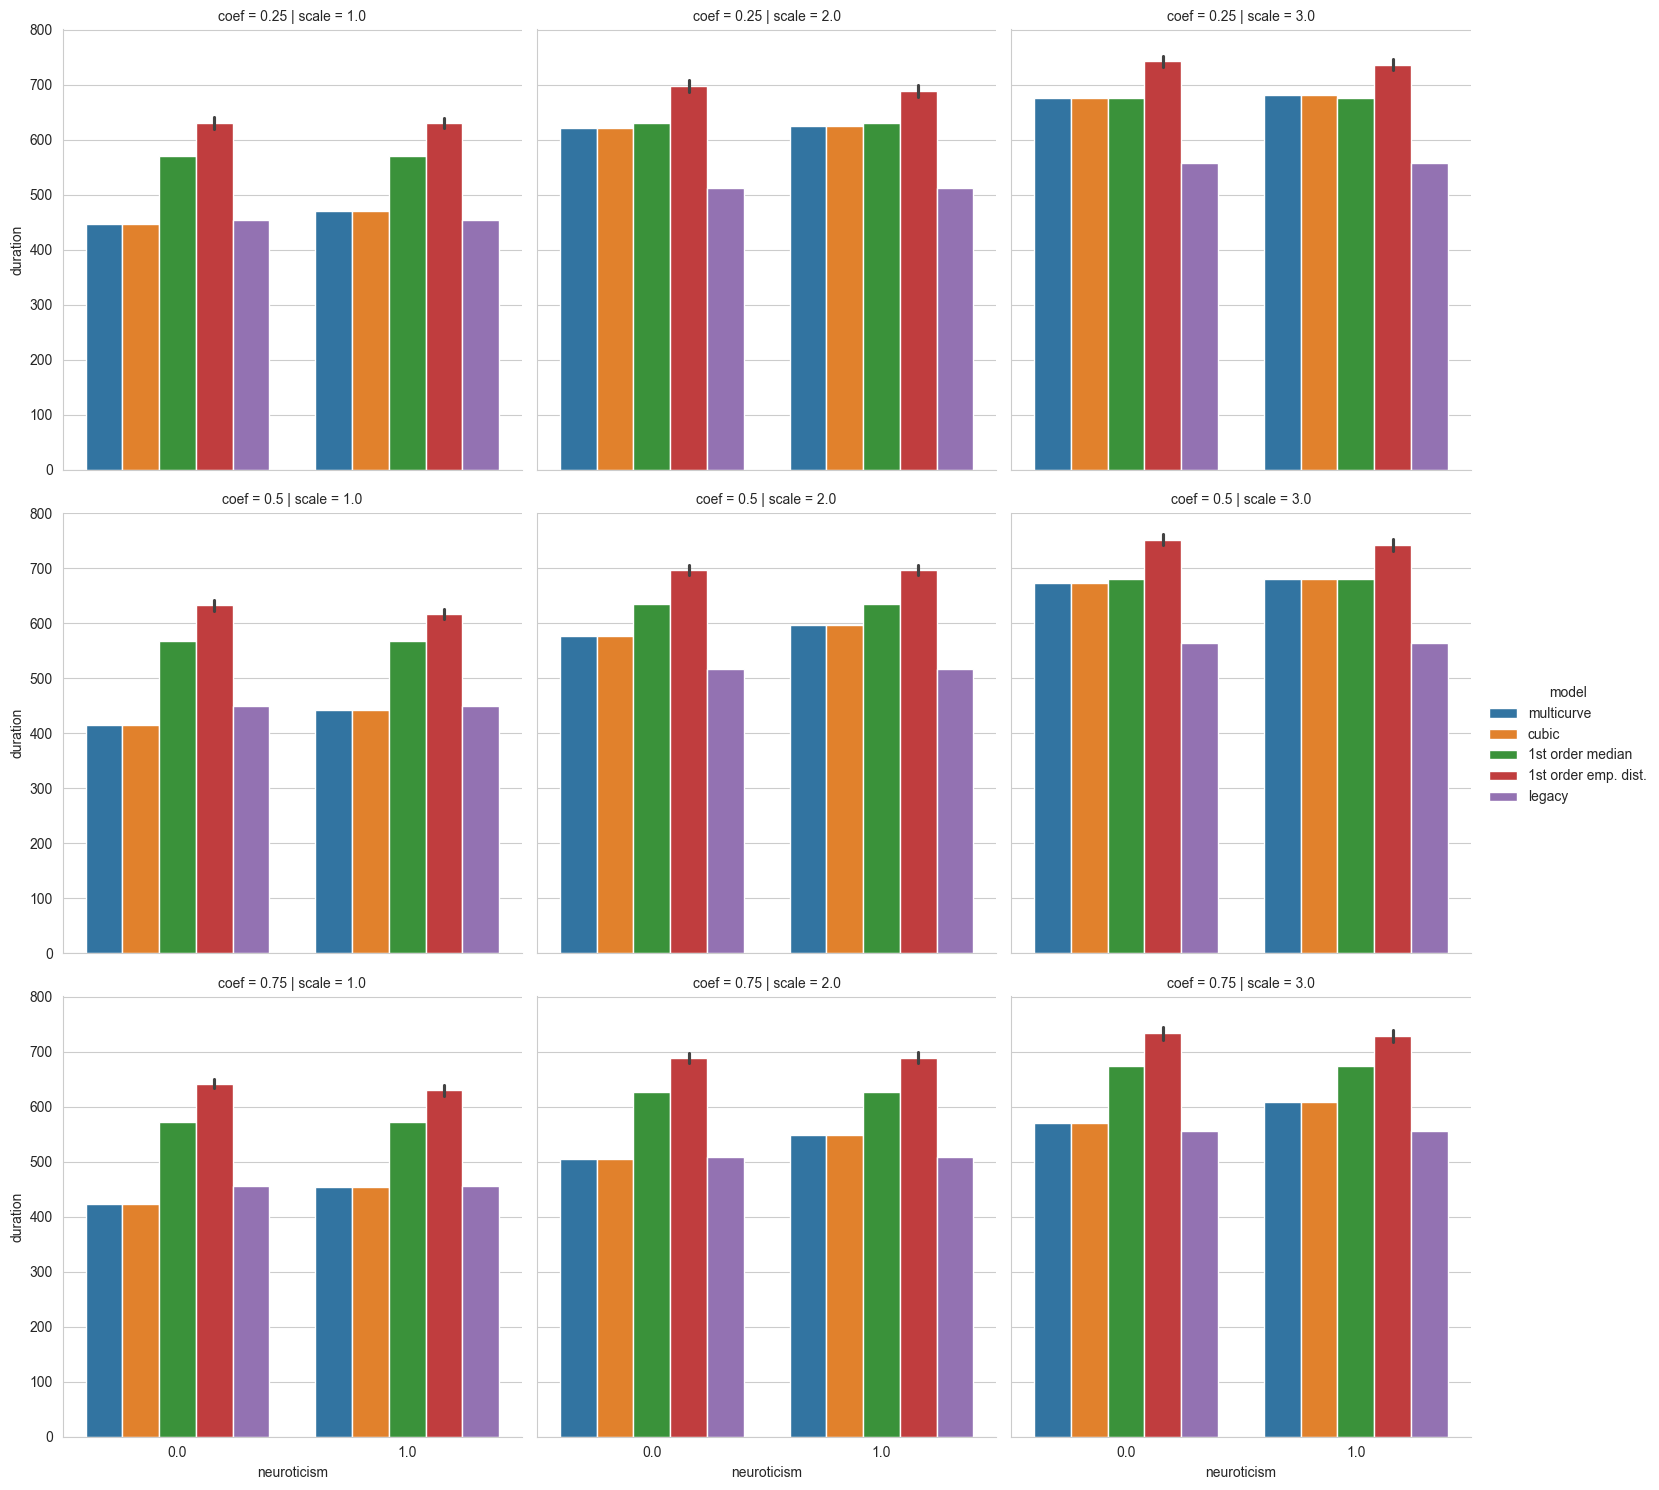

In [12]:
fg = sns.catplot(
    kind="bar",
    data=results.query("step == 99"),
    hue="model",
    y="duration",
    x="neuroticism",
    col="scale",
    row="coef",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
# fg.fig.tight_layout()
plt.show()
plt.close()